In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import torch
import pandas as pd
from datasets import load_dataset
from datasets import Dataset


In [3]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.9 MB/s eta 0:00:00


In [4]:
import evaluate

In [19]:
df = pd.read_csv("/kaggle/input/news-category-under-sampled/cat_cleaned.csv")

In [20]:
df['labels'] = df['labels'].replace(["BUSINESS", "ENTERTAINMENT", "SPORTS", "OTHER"] ,[0, 1, 2, 3])

/tmp/ipykernel_33/3742779329.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['labels'] = df['labels'].replace(["BUSINESS", "ENTERTAINMENT", "SPORTS", "OTHER"] ,[0, 1, 2, 3])


In [6]:
df['labels'].value_counts()

labels
0    6823
3    6531
1    6484
2    5915
Name: count, dtype: int64

In [21]:
raw_data = Dataset.from_pandas(df)

In [22]:
split_data = raw_data.train_test_split(test_size=0.1)

In [5]:
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [23]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [24]:
tokenized_data = split_data.map(preprocess_function, batched = True)

  0%|          | 0/24 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [6]:
from transformers import DataCollatorWithPadding

In [7]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [8]:
import numpy as np

In [9]:
accuracy = evaluate.load('accuracy')

In [10]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [11]:
id2label = {0: "BUSINESS", 1: "ENTERTAINMENT", 2: "SPORTS", 3: "OTHER"}
label2id = {"BUSINESS": 0, "ENTERTAINMENT" : 1, "SPORTS" : 2, "OTHER" : 3}


In [18]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilroberta-base",  num_labels=4, id2label=id2label, label2id=label2id
)

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
early_stop = EarlyStoppingCallback(2)

In [20]:
training_args = TrainingArguments(
    report_to="wandb",
    output_dir="DistilroBERTa-cat_df",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

In [22]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stop]
)

In [ ]:
trainer.save_model("Distil-RoBERTa-base")

In [23]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ························


wandb: ERROR API key must be 40 characters long, yours was 24
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.379500,0.350176,0.895575
2,0.311400,0.376321,0.908773
3,0.250400,0.381997,0.911879


TrainOutput(global_step=8694, training_loss=0.3251323520054015, metrics={'train_runtime': 2088.0443, 'train_samples_per_second': 44.399, 'train_steps_per_second': 5.552, 'total_flos': 8998552426102512.0, 'train_loss': 0.3251323520054015, 'epoch': 3.0})

In [4]:
from transformers import pipeline

In [5]:
import pandas as pd

In [25]:
classifier = pipeline('text-classification', model="/kaggle/input/distilroberta-full-cat/Distil-Roberta-cat", 
                      device=0 if torch.cuda.is_available() else -1,)


In [27]:
test_df = pd.read_csv("/kaggle/input/huffdata-undersampled4k/huffdata_under18k.csv")

In [28]:
raw_data = Dataset.from_pandas(test_df)

In [29]:
split_data = raw_data.train_test_split(test_size=0.05)

In [30]:
split_data['test']

Dataset({
    features: ['text', 'labels'],
    num_rows: 926
})

In [30]:
label2id = {"BUSINESS": 0, "ENTERTAINMENT" : 1, "SPORTS" : 2, "OTHER" : 3}

In [31]:
def test_pipeline(df):
    X = list(df['text'])
    y_act = list(df['labels'])
    labels = list(label2id.keys())
    return X, y_act, labels

In [32]:
X, y_act, labels = test_pipeline(split_data['test'])

In [34]:
len(X)

926

In [33]:
y_pred = [result["label"] for result in classifier(X, padding=True, truncation=True)]

In [34]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

In [35]:
print(classification_report(y_pred, y_act, labels=labels))

               precision    recall  f1-score   support

     BUSINESS       0.88      0.92      0.90       237
ENTERTAINMENT       0.89      0.84      0.86       249
       SPORTS       0.99      0.93      0.96       253
        OTHER       0.70      0.78      0.73       187

     accuracy                           0.87       926
    macro avg       0.87      0.86      0.86       926
 weighted avg       0.88      0.87      0.87       926



In [36]:
cm = confusion_matrix(y_act, y_pred, labels=labels)

In [37]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)


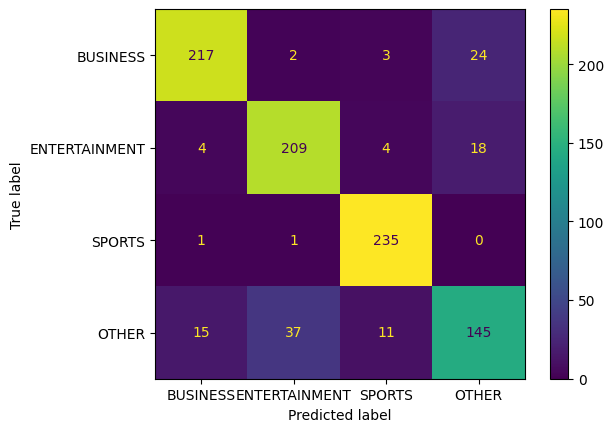

In [38]:
disp.plot()

In [15]:
classifier = pipeline('text-classification', model="/kaggle/working/Distil-RoBERTa-base", 
                      device=0 if torch.cuda.is_available() else -1,)


In [19]:
y_pred = [result["label"] for result in classifier(X, padding=True, truncation=True)]

In [20]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

In [21]:
print(classification_report(y_act, y_pred, labels=labels))

               precision    recall  f1-score   support

     BUSINESS       0.00      0.00      0.00       269
ENTERTAINMENT       0.27      1.00      0.42       247
       SPORTS       0.00      0.00      0.00       226
        OTHER       0.00      0.00      0.00       184

     accuracy                           0.27       926
    macro avg       0.07      0.25      0.11       926
 weighted avg       0.07      0.27      0.11       926



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
cm = confusion_matrix(y_act, y_pred, labels=labels)

In [23]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)


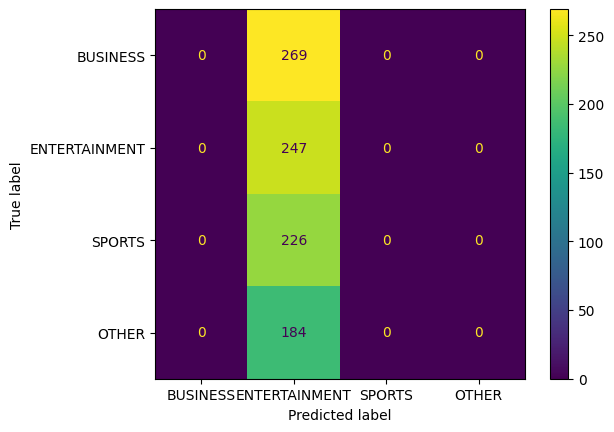

In [24]:
disp.plot()